# BLG641E- Medical Image Computing

## Coursework - Age regression from brain MRI

Predicting the age from a brain MRI scan is believed to have diagnostic value in the context of a number of pathologies that cause structural changes and damage to the brain. Assuming an accurate predictor of brain age can be trained based on a set of healthy subjects, the idea is then to compare the predicted age obtained on a new patient scan with the real age of that patient. Discrepancy between predicted and real age might indicate the presence of pathology and abnormal changes to the brain.

The objective for the coursework is to implement two different supervised learning approaches for age regression from brain MRI data. Data from 652 subjects will be provided. Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are dedicated sections in the Jupyter notebook for each approach which contain some detailed instructions and some hints and notes.

For many tasks, you will find useful ideas and implementations in the tutorial notebooks. Make sure to add documentation to your code. Markers will find it easier to understand your reasoning when sufficiently detailed comments are provided in your implementations.

#### Read the descriptions and provided code cells carefully and look out for the cells marked with 'TASK'.

In [17]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Getting started

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the population of 652 subjects. Let's start by loading the meta data, that is the data containing information about the subject IDs, their age, and gender.

In [1]:
# Read the meta data using pandas
import pandas as pd

data_dir = 'project-data/'

meta_data = pd.read_csv(data_dir + 'meta/clean_participant_data.csv')
meta_data.head() # show the first five data entries

,ID,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look the the population statistics.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


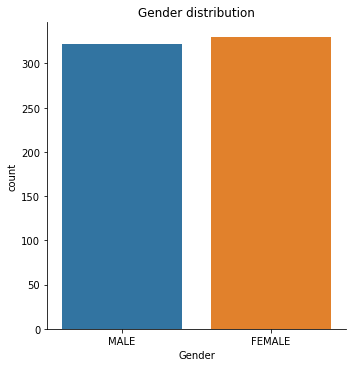

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


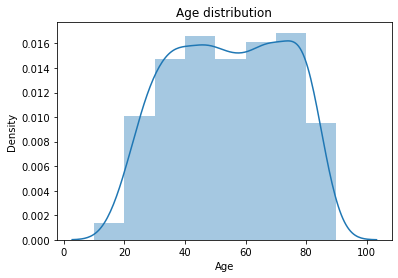

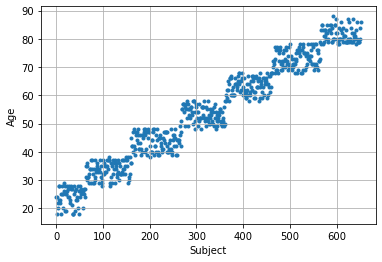

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.factorplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up the image viewer

In [3]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

In [5]:
interactive_view(img)

interactive(children=(IntSlider(value=63, description='x', max=127), IntSlider(value=75, description='y', max=…

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


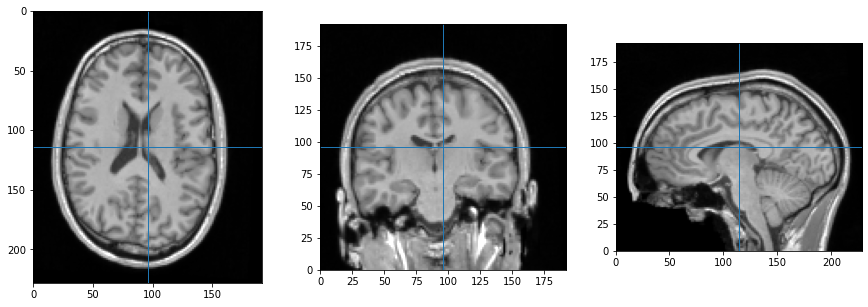

Brain mask (used in part A)


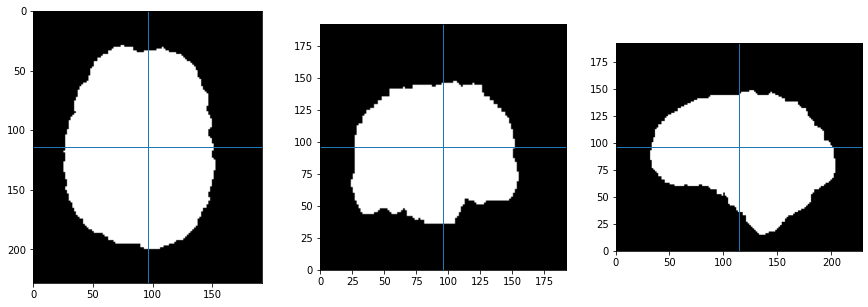

Spatially normalised grey matter maps (used in part B)


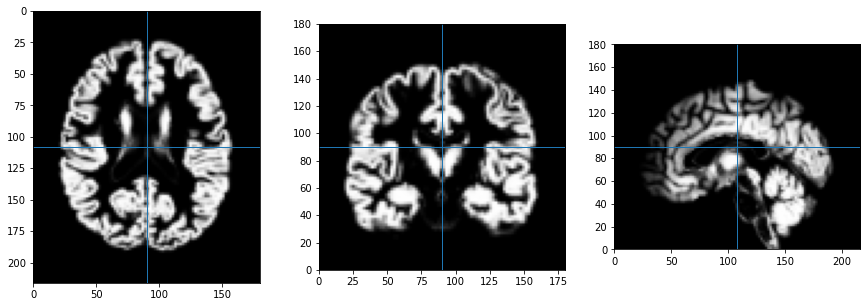

In [4]:
import glob

# Subject with index 0
ID = meta_data['ID'][0]
age = meta_data['age'][0]

# Data folders
image_dir = data_dir + 'images/'
image_filenames = glob.glob(image_dir + '*.nii.gz')

mask_dir = data_dir + 'masks/'
mask_filenames = glob.glob(mask_dir + '*.nii.gz')

greymatter_dir = data_dir + 'greymatter/'
greymatter_filenames = glob.glob(greymatter_dir + '*.nii.gz')


image_filename = [f for f in image_filenames if ID in f][0]
img = sitk.ReadImage(image_filename)

mask_filename = [f for f in mask_filenames if ID in f][0]
msk = sitk.ReadImage(mask_filename)

greymatter_filename = [f for f in greymatter_filenames if ID in f][0]
gm = sitk.ReadImage(greymatter_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

The first approach aims to regress the age of a subject from the volumes of brain tissues, including grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume might decrease. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a three-class brain tissue segmentation needs to be implemented and applied to the provided 652 brain scans. Brain masks are provided which have been generated with a state-of-the-art brain extraction tool from the FSL toolkit.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a hypothesis with higher order polynomials? How about other regression methods such as support vector regression or regression trees? The accuracy of different methods should be evaluated using cross-validation, and average prediction accuracy should be reported.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B only.

### TASK A-1: Brain tissue segmentation

Implement a brain tissue segmentation method which provides segmentations of GM, WM, and CSF. Apply this method to all 652 MR images, and calculate the three tissue volumes for each subject.

*Hint:* For the segmentation method, you may want to make use of the provided brain masks to constrain your segmentation to brain voxels (compare tutorial 3).

*Note:* For more efficient experimentation, you may want to initially restrict computations to the first five or so images. Once you're happy with the segmentation results, apply the method to all 652 images (which may take a while to run). You may also want to save the registration results using `sitk.WriteImage`, so you don't have to run the segmentation each time from scratch but instead load the stored results.

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak

In [7]:
age = meta_data['age']

In [8]:
age[0]

24

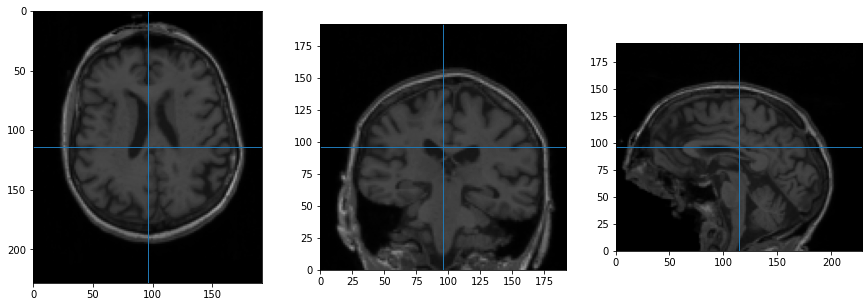

In [9]:
#Get 652 images 
images=[]
for i in range(len(image_filenames)):
    images.append(sitk.ReadImage(image_filenames[i]))
display_image(images[651])

In [13]:
#get arrays from images
train_images_array=[]
for i in range(0,600):
    train_images_array.append(sitk.GetArrayFromImage(images[i]))
train_images_array_np=np.array(train_images_array)

test_images_array=[]
for i in range(600,652):
    test_images_array.append(sitk.GetArrayFromImage(images[i]))
test_images_array_np=np.array(test_images_array)

In [14]:
agee=age[0:600]

In [15]:
# Initialize the image regressor.
reg = ak.ImageRegressor(overwrite=True, max_trials=1)
# Feed the image regressor with training data.
reg.fit(train_images_array_np, agee, epochs=400)

Trial 1 Complete [00h 23m 41s]
val_loss: 1032.5753173828125

Best val_loss So Far: 1032.5753173828125
Total elapsed time: 00h 23m 41s
INFO:tensorflow:Oracle triggered exit
Epoch 1/400
19/19 [==============================] - 46s 2s/step - loss: 373.9846 - mean_squared_error: 373.9846
Epoch 2/400
19/19 [==============================] - 44s 2s/step - loss: 564.1707 - mean_squared_error: 564.1707
Epoch 3/400
19/19 [==============================] - 43s 2s/step - loss: 1078.4453 - mean_squared_error: 1078.4453
Epoch 4/400
19/19 [==============================] - 43s 2s/step - loss: 560.9112 - mean_squared_error: 560.9112
Epoch 5/400
19/19 [==============================] - 43s 2s/step - loss: 559.9293 - mean_squared_error: 559.9293
Epoch 6/400
19/19 [==============================] - 44s 2s/step - loss: 511.4028 - mean_squared_error: 511.4028
Epoch 7/400
19/19 [==============================] - 44s 2s/step - loss: 748.0240 - mean_squared_error: 748.0240
Epoch 8/400
19/19 [================

19/19 [==============================] - 42s 2s/step - loss: 28.2076 - mean_squared_error: 28.2076
Epoch 145/400
19/19 [==============================] - 42s 2s/step - loss: 20.1633 - mean_squared_error: 20.1633
Epoch 146/400
19/19 [==============================] - 42s 2s/step - loss: 59.6279 - mean_squared_error: 59.6279
Epoch 147/400
19/19 [==============================] - 42s 2s/step - loss: 40.2296 - mean_squared_error: 40.2296
Epoch 148/400
19/19 [==============================] - 42s 2s/step - loss: 55.4979 - mean_squared_error: 55.4979
Epoch 149/400
19/19 [==============================] - 42s 2s/step - loss: 40.2140 - mean_squared_error: 40.2140
Epoch 150/400
19/19 [==============================] - 42s 2s/step - loss: 23.6086 - mean_squared_error: 23.6086
Epoch 151/400
19/19 [==============================] - 42s 2s/step - loss: 57.5943 - mean_squared_error: 57.5943
Epoch 152/400
19/19 [==============================] - 42s 2s/step - loss: 29.8379 - mean_squared_error: 29.83

19/19 [==============================] - 40s 2s/step - loss: 45.0459 - mean_squared_error: 45.0459
Epoch 289/400
19/19 [==============================] - 40s 2s/step - loss: 87.9715 - mean_squared_error: 87.9715
Epoch 290/400
19/19 [==============================] - 40s 2s/step - loss: 29.0015 - mean_squared_error: 29.0015
Epoch 291/400
19/19 [==============================] - 40s 2s/step - loss: 36.0849 - mean_squared_error: 36.0849
Epoch 292/400
19/19 [==============================] - 40s 2s/step - loss: 28.0673 - mean_squared_error: 28.0673
Epoch 293/400
19/19 [==============================] - 39s 2s/step - loss: 15.1407 - mean_squared_error: 15.1407
Epoch 294/400
19/19 [==============================] - 40s 2s/step - loss: 8.0948 - mean_squared_error: 8.0948
Epoch 295/400
19/19 [==============================] - 40s 2s/step - loss: 6.9176 - mean_squared_error: 6.9176
Epoch 296/400
19/19 [==============================] - 39s 2s/step - loss: 9.1022 - mean_squared_error: 9.1022
Epo

19/19 [==============================] - 40s 2s/step - loss: 1.7004 - mean_squared_error: 1.7004
Epoch 362/400
19/19 [==============================] - 40s 2s/step - loss: 0.9327 - mean_squared_error: 0.9327
Epoch 363/400
19/19 [==============================] - 40s 2s/step - loss: 1.3253 - mean_squared_error: 1.3253
Epoch 364/400
19/19 [==============================] - 40s 2s/step - loss: 0.8100 - mean_squared_error: 0.8100
Epoch 365/400
19/19 [==============================] - 40s 2s/step - loss: 1.0178 - mean_squared_error: 1.0178
Epoch 366/400
19/19 [==============================] - 40s 2s/step - loss: 0.9190 - mean_squared_error: 0.9190
Epoch 367/400
19/19 [==============================] - 41s 2s/step - loss: 0.9247 - mean_squared_error: 0.9247
Epoch 368/400
19/19 [==============================] - 41s 2s/step - loss: 0.9287 - mean_squared_error: 0.9287
Epoch 369/400
19/19 [==============================] - 40s 2s/step - loss: 0.9485 - mean_squared_error: 0.9485
Epoch 370/400
1

In [16]:
# Predict with the best model.
predicted_y = reg.predict(test_images_array_np)
print(predicted_y)


# Evaluate the best model with testing data.
print(reg.evaluate(test_images_array_np, age[600:652]))

2/2 [==============================] - 2s 618ms/step
[[52.570587]
 [52.201336]
 [51.047848]
 [50.908638]
 [56.45303 ]
 [54.396   ]
 [52.854305]
 [53.645752]
 [54.703396]
 [52.396328]
 [55.939926]
 [52.401306]
 [55.871788]
 [54.61983 ]
 [50.86472 ]
 [55.379864]
 [51.00762 ]
 [51.759735]
 [52.74587 ]
 [57.49342 ]
 [54.02421 ]
 [53.42707 ]
 [49.497776]
 [52.39405 ]
 [52.98499 ]
 [52.0237  ]
 [52.01756 ]
 [50.79465 ]
 [53.952637]
 [58.23586 ]
 [51.007187]
 [53.740704]
 [50.49468 ]
 [53.498135]
 [54.842884]
 [51.019035]
 [52.18463 ]
 [55.57339 ]
 [52.388783]
 [52.815334]
 [53.474907]
 [54.994   ]
 [52.429752]
 [47.844162]
 [52.559807]
 [48.48101 ]
 [56.980873]
 [53.887722]
 [46.661316]
 [51.04774 ]
 [55.067936]
 [53.76536 ]]
2/2 [==============================] - 4s 1s/step - loss: 801.4246 - mean_squared_error: 801.4246
[801.424560546875, 801.424560546875]


### TASK A-2: Feature calculation

Implement a function that calculates volume features given the three tissue volumes and the overal brain volume (which can be calculated from the brain masks). You should use this function to construct a big matrix $X$ with a row for each subject and features across the columns.

*Note:* You may need to experiment here what the best set of features is. Start with just calculating three simple features of relative tissue volumes. So you should initially construct an $X^{652 \times 3}$.

In [ ]:
import os
from collections import Counter
from collections import defaultdict
seg_dir = data_dir + './segs_refs/'
vols = np.zeros((3,meta_data['ID'].count())) # 3 row 600 cols
print('total count is', meta_data['ID'].count())

ageVolumn = defaultdict(np.array)
age = list(meta_data['age'])
for i in range(meta_data['ID'].count()):
    ID = meta_data['ID'][i]
    img = sitk.ReadImage(seg_dir+ID+'.nii.gz')
    img_array = sitk.GetArrayFromImage(img) 
    seg = resample_image(img,img_spacing,img_size)
    seg_array = sitk.GetArrayFromImage(seg) 
    frq = Counter(seg_array.flatten())
    unit = img_spacing[0]*img_spacing[1]*img_spacing[2]
    vols[:,i] = np.array([frq[1]*unit,frq[2]*unit,frq[3]*unit])
    ageVolumn[meta_data['age'][i]] = ageVolumn.get(meta_data['age'][i],np.array([0,0,0])) + np.array([frq[1]*unit,frq[2]*unit,frq[3]*unit])
    
    

In [10]:
img_masked.GetSize()

(128, 152, 128)

Masked image


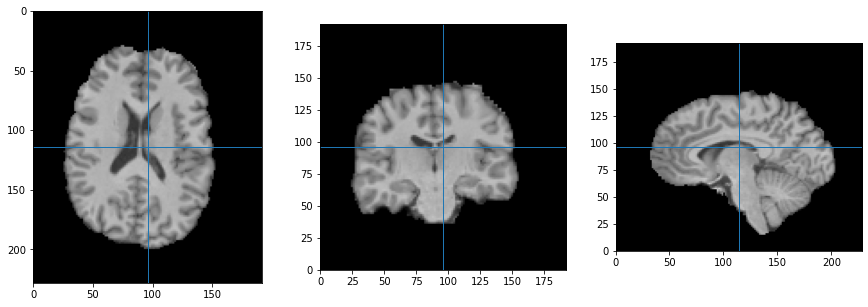

In [19]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

masked_array = img_array
masked_array[msk_array==0] = 0

img_masked = sitk.GetImageFromArray(masked_array)
img_masked.CopyInformation(img)

print('Masked image')
display_image(img_masked, window=400, level=200)

In [11]:
import os
data_dir = 'project-data/images/'
Image_list=os.listdir(data_dir)
GT_list=os.listdir(data_dir)

CSF=0
GM=0
WM=0

CSF_List=[]
GM_List=[]
WM_List=[]

In [14]:
for i in range(len(Image_list)):
        print("Print the Dice for Validation Image: ",Image_list[i])

        #Segmentation
        prediction = sitk.ReadImage(data_dir+Image_list[i],sitk.sitkInt8) 
        prediction_img=sitk.GetArrayFromImage(prediction)

        #Groud Truth
        GT = sitk.ReadImage(data_dir + GT_list[i],sitk.sitkInt8)
        GT_img=sitk.GetArrayFromImage(GT)

        ###CALCLATING THE Dice
        dice_CSF, dice_GM, dice_WM = dice_similarity(prediction_img,GT_img,"arr")
        print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

        ###
        CSF_List.append(dice_CSF)
        GM_List.append(dice_GM)
        WM_List.append(dice_WM)


Print the Dice for Validation Image:  msub-CC321428_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC410297_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC121106_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC410226_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC221828_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620264_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120313_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120008_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520175_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520287_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC720238_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320680_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520239_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620129_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620284_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120319_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320893_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC721052_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC220506_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC121685_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520390_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC222304_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC321107_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC610508_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320160_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC220843_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620279_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC110411_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC321595_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710518_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520247_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710982_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC720986_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC310129_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC221977_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520134_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320686_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC321331_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120049_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710214_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC510355_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC610099_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC410119_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC621284_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC222120_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC321504_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC210023_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC220713_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC420061_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620479_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620118_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC510609_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320661_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC620405_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC221935_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC420582_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC610046_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710486_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710551_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520424_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC220974_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC110069_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC110098_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320325_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC321585_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC520168_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC410248_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC710416_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120120_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC120640_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC722421_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC720071_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC220610_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC510015_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC410113_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC420286_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC320776_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC721377_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC420182_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print the Dice for Validation Image:  msub-CC310008_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = 1.0 WM DICE = 1.0
Print

In [43]:
#Get first 100 images 
images=[]
for i in range(len(image_filenames)):
    images.append(sitk.ReadImage(image_filenames[i]))
display_image(images[651])

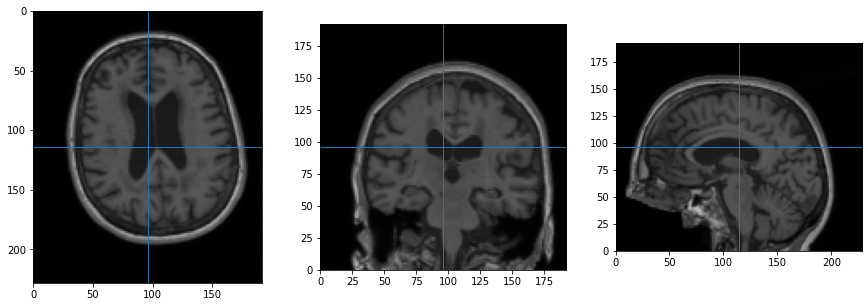

In [46]:

display_image(images[651])

In [ ]:
images_array=[]
for i in range(len(image_filenames)):
    images_array.append(sitk.GetArrayFromImage(images[i]))
images_array_np=np.array(images_array)

In [40]:
images_array_np

array([[[[2.7148131e-01, 2.5318220e+00, 1.0009222e+00, ...,
          2.3156879e+00, 1.6306213e+00, 9.2859119e-01],
         [1.0663640e+00, 2.8252795e+00, 2.7724080e+00, ...,
          3.2736182e+00, 2.8745654e+00, 1.4841723e+00],
         [3.0820808e+00, 1.3478074e+00, 2.6757252e+00, ...,
          3.9783378e+00, 1.8267716e+00, 2.6931612e+00],
         ...,
         [1.6863772e+00, 2.5609438e+00, 2.6196630e+00, ...,
          3.0563760e+00, 8.2618296e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.3475291e-01, 1.9575796e-01, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[1.1351732e+00, 2.0404756e+00, 1.1263411e+00, ...,
          2.4852695e+00, 1.8355806e+00, 1.4695741e+00],
         [1.5396622e+00, 2.5279255e+00, 1.5642073e+00, ...,
          3.7171938e+00, 2.7738836e+00, 3.0482867e+00],
         [2.8424959e+00, 1.3258973e+00, 1.9572994e+00, .

In [70]:
#Get trainX and testX for 100 images
trainX=[]
testX=[]
for i in range(len(images)):
    trainX.append(images[i])
    if i>70:
        testX.append(images[i])


In [107]:
#Get trainX and trainY for 1 image
trainX=images[0]
trainX_img_array=sitk.GetArrayFromImage(trainX)
trainX_img_array = trainX_img_array/trainX_img_array.mean()
trainY=meta_data['age'][0:1]
trainX_img_array.shape


(128, 152, 128)

In [84]:

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [49]:
#Get trainY and testY
trainY=meta_data['age'][0:70]
testY=meta_data['age'][71:101]

In [72]:
#Get arrays from trainX
trainX_img_array=[]
for i in range(len(trainX)):
    trainX_img_array.append(sitk.GetArrayFromImage(trainX[i]))

In [36]:
#Get arrays from testX
testX_img_array=[]
for i in range(len(testX)):
    testX_img_array.append(sitk.GetArrayFromImage(testX[i]))

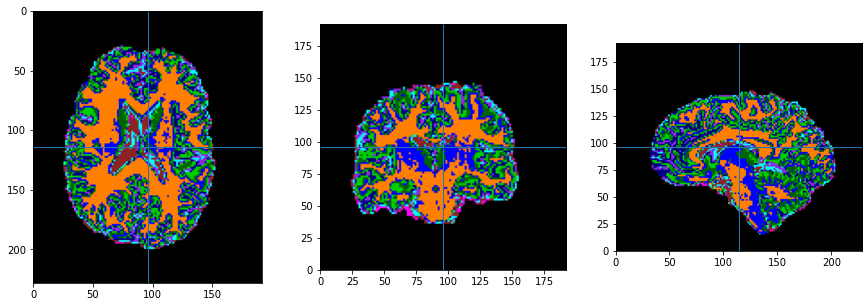

In [16]:
import sklearn.cluster as cluster
num_clusters = 9
# Create a k-means instance
kmeans = cluster.KMeans(n_clusters=num_clusters)
X = img_array[msk_array > 0].flatten().reshape(-1, 1)

# Get the number of points
num_pts = len(X.flatten())
sampling = 0.05
X_subset = np.random.choice(X.flatten(),int(num_pts*sampling)).reshape(-1, 1)
# Running k-means via the fit function
kmeans.fit(X_subset)

# Produce the clustering result for all image points
y = kmeans.predict(img_array.flatten().reshape(-1, 1))

# K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

# Construct a 3D label map
lab_array = y.reshape(img_array.shape).astype('uint8')
seg_kmeans = sitk.GetImageFromArray(lab_array)
seg_kmeans.CopyInformation(img)

# Display the results using SimpleITK mapping of label maps to colours
display_image(sitk.LabelToRGB(seg_kmeans))

### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remmeber to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 652 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least two different regression methods.

*Hint:* This [scikit-learn example](http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html#sphx-glr-auto-examples-plot-cv-predict-py) might be useful.

In [13]:
def dice_similarity(Seg_img, GT_img,state):
    """   
    Inputs:
        Seg_img (numpy.ndarray): Segmented Image.
        GT_img (numpy.ndarray): Ground Truth Image.
        State: "nifti" if the images are nifti file
               "arr"   if the images are an ndarray
    output:
        Dice Similarity Coefficient: dice_CSF, dice_GM, dice_WM."""
    
    if (state=="nifti"):
        segmented_data = Seg_img.get_data().copy()
        groundtruth_data = GT_img.get_data().copy()
    elif (state=="arr"):
        segmented_data = Seg_img.copy()
        groundtruth_data = GT_img.copy()
    
    #Calculte DICE
    def dice_coefficient(SI,GT):
        #   2 * TP / (FN + (2 * TP) + FP)
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    #Dice  for CSF
    Seg_CSF = (segmented_data == 1) * 1
    GT_CSF = (groundtruth_data == 1) * 1
    dice_CSF = dice_coefficient(Seg_CSF, GT_CSF)
    #Dice  for GM
    Seg_GM = (segmented_data == 2) * 1
    GT_GM = (groundtruth_data == 2) * 1
    dice_GM = dice_coefficient(Seg_GM, GT_GM)
    #Dice  for WM
    Seg_WM = (segmented_data == 3) * 1
    GT_WM = (groundtruth_data == 3) * 1
    dice_WM = dice_coefficient(Seg_WM, GT_WM)
    
    return dice_CSF, dice_GM, dice_WM

## Part B: Image-based regression using grey matter maps

The second approach will make use of grey matter maps that have been already extracted from the set of MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the MNI atlas (compare slide 99 of the Segmentation lecture).

Because the grey matter maps are spatially normalised, voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large, there would be a very large number of features to deal with. A dimensionality reduction using PCA needs to be performed before training a suitable regressor on the low-dimensional feature representation obtained with PCA. It might also be beneficial to apply some pre-processing before running PCA, which should be explored. The implemented pipeline should be evaluated using cross-validation using the same data splits as in part A, so the two approaches can be directly compared.

*Note:* For part B, only the spatially normalised grey matter maps should be used.

### TASK B-1: Pre-processing

Before running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis, such as training a regressor where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation that had been applied to the maps.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed, before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues.

Implement a function that performs suitable pre-processing on each grey matter map.

*Hint:* Check out tutorial 1. You may want to save the pre-processed maps using `sitk.WriteImage` to avoid recomputation.

In [22]:

#Get 652 greymatter images 
greymatter=[]
for i in range(len(greymatter_filenames)):
    greymatter.append(sitk.ReadImage(greymatter_filenames[i]))


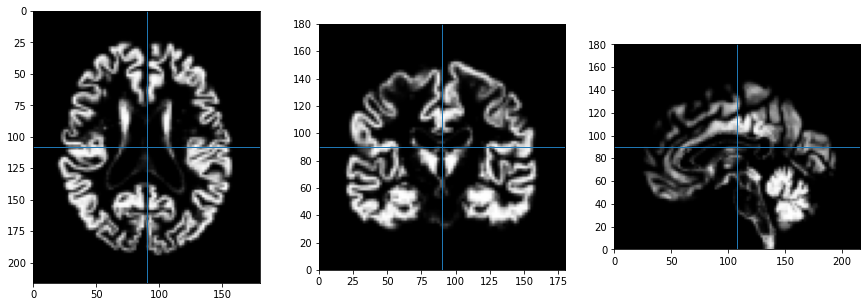

In [23]:
display_image(greymatter[651])

In [24]:
#get arrays from images
train_greymatter_array=[]
for i in range(0,600):
    train_greymatter_array.append(sitk.GetArrayFromImage(greymatter[i]))
train_greymatter_array_np=np.array(train_greymatter_array)

test_greymatter_array=[]
for i in range(600,652):
    test_greymatter_array.append(sitk.GetArrayFromImage(greymatter[i]))
test_greymatter_array_np=np.array(test_greymatter_array)

In [25]:
agee=age[0:600]

In [26]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False,
)(input_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=1
)

reg.fit(train_greymatter_array_np, agee, epochs=300)


Trial 1 Complete [01h 00m 30s]
val_loss: 125.7857666015625

Best val_loss So Far: 125.7857666015625
Total elapsed time: 01h 00m 30s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
19/19 [==============================] - 112s 6s/step - loss: 1338.9283 - mean_squared_error: 1338.9283
Epoch 2/300
19/19 [==============================] - 100s 5s/step - loss: 614.2608 - mean_squared_error: 614.2608
Epoch 3/300
19/19 [==============================] - 100s 5s/step - loss: 884.5423 - mean_squared_error: 884.5423
Epoch 4/300
19/19 [==============================] - 99s 5s/step - loss: 351.8135 - mean_squared_error: 351.8135
Epoch 5/300
19/19 [==============================] - 99s 5s/step - loss: 351.5762 - mean_squared_error: 351.5762
Epoch 6/300
19/19 [==============================] - 99s 5s/step - loss: 288.3269 - mean_squared_error: 288.3269
Epoch 7/300
19/19 [==============================] - 99s 5s/step - loss: 210.9682 - mean_squared_error: 210.9682
Epoch 8/300
19/19 [===============

19/19 [==============================] - 99s 5s/step - loss: 10.7953 - mean_squared_error: 10.7953
Epoch 144/300
19/19 [==============================] - 99s 5s/step - loss: 8.9432 - mean_squared_error: 8.9432
Epoch 145/300
19/19 [==============================] - 99s 5s/step - loss: 16.3754 - mean_squared_error: 16.3754
Epoch 146/300
19/19 [==============================] - 98s 5s/step - loss: 9.8344 - mean_squared_error: 9.8344
Epoch 147/300
19/19 [==============================] - 99s 5s/step - loss: 18.3853 - mean_squared_error: 18.3853
Epoch 148/300
19/19 [==============================] - 99s 5s/step - loss: 11.1781 - mean_squared_error: 11.1781
Epoch 149/300
19/19 [==============================] - 98s 5s/step - loss: 12.5801 - mean_squared_error: 12.5801
Epoch 150/300
19/19 [==============================] - 98s 5s/step - loss: 17.8678 - mean_squared_error: 17.8678
Epoch 151/300
19/19 [==============================] - 99s 5s/step - loss: 14.0393 - mean_squared_error: 14.0393
E

19/19 [==============================] - 97s 5s/step - loss: 0.3107 - mean_squared_error: 0.3107
Epoch 289/300
19/19 [==============================] - 98s 5s/step - loss: 0.3850 - mean_squared_error: 0.3850
Epoch 290/300
19/19 [==============================] - 98s 5s/step - loss: 0.3170 - mean_squared_error: 0.3170
Epoch 291/300
19/19 [==============================] - 98s 5s/step - loss: 0.3319 - mean_squared_error: 0.3319
Epoch 292/300
19/19 [==============================] - 97s 5s/step - loss: 0.4212 - mean_squared_error: 0.4212
Epoch 293/300
19/19 [==============================] - 97s 5s/step - loss: 0.3078 - mean_squared_error: 0.3078
Epoch 294/300
19/19 [==============================] - 97s 5s/step - loss: 0.5233 - mean_squared_error: 0.5233
Epoch 295/300
19/19 [==============================] - 97s 5s/step - loss: 0.3100 - mean_squared_error: 0.3100
Epoch 296/300
19/19 [==============================] - 97s 5s/step - loss: 0.6467 - mean_squared_error: 0.6467
Epoch 297/300
1

In [27]:
# Predict with the best model.
predicted_y = reg.predict(test_greymatter_array_np)
print(predicted_y)


# Evaluate the best model with testing data.
print(reg.evaluate(test_greymatter_array_np, age[600:652]))

2/2 [==============================] - 4s 1s/step
[[54.692734]
 [53.200176]
 [53.339504]
 [59.54794 ]
 [54.071293]
 [53.15829 ]
 [55.381123]
 [56.98374 ]
 [54.424877]
 [56.794785]
 [59.388546]
 [55.28288 ]
 [57.819138]
 [57.778484]
 [60.112217]
 [59.047577]
 [59.74559 ]
 [54.632057]
 [57.6116  ]
 [54.949482]
 [53.69079 ]
 [58.325413]
 [55.334316]
 [49.70315 ]
 [58.000267]
 [55.75321 ]
 [57.795357]
 [56.890484]
 [54.16209 ]
 [57.447136]
 [55.343212]
 [57.817482]
 [50.673157]
 [51.06982 ]
 [52.8905  ]
 [53.92614 ]
 [55.794918]
 [53.41599 ]
 [56.012775]
 [58.39704 ]
 [57.578876]
 [61.7557  ]
 [57.759434]
 [56.601646]
 [54.141293]
 [57.534973]
 [52.900845]
 [58.468754]
 [56.32107 ]
 [58.06572 ]
 [56.16306 ]
 [54.95031 ]]
2/2 [==============================] - 5s 2s/step - loss: 638.8029 - mean_squared_error: 638.8029
[638.8028564453125, 638.8028564453125]


In [49]:
def visualize_dices(groudtruth_path, Segmented_data_path):

    Image_list=os.listdir(Segmented_data_path)
    GT_list=os.listdir(groudtruth_path)

    CSF=0
    GM=0
    WM=0

    CSF_List=[]
    GM_List=[]
    WM_List=[]


    for i in range(0,5):
        print("Print the Dice for Validation Image: ",Image_list[i])

        #Segmentation
        prediction = sitk.ReadImage(Segmented_data_path+Image_list[i],sitk.sitkInt8) 
        prediction_img=sitk.GetArrayFromImage(prediction)

        #Groud Truth
        GT = sitk.ReadImage(groudtruth_path + GT_list[i],sitk.sitkInt8)
        GT_img=sitk.GetArrayFromImage(GT)

        ###CALCLATING THE Dice
        dice_CSF, dice_GM, dice_WM = dice_similarity(prediction_img,GT_img,"arr")
        print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

        ###
        CSF_List.append(dice_CSF)
        GM_List.append(dice_GM)
        WM_List.append(dice_WM)

        ####

    df=pd.DataFrame(list(zip(CSF_List,GM_List,WM_List)),
    columns=['CSF','GM','WM'])
    
    Average_CSF=df['CSF'].mean()
    Average_GM=df['GM'].mean()
    Average_WM=df['WM'].mean()
    
    Std_CSF=df['CSF'].std()
    Std_GM=df['GM'].std()
    Std_WM=df['WM'].std()
    
    #print("Avg_CSF DICE = {} ± {}".format(Average_CSF,Std_CSF), "Avg_GM DICE = {}".format(Average_GM), "Avg_WM DICE = {}".format(Average_WM))
    
    
    print("###Printing Avg ± Standard Daviation###")
    print("Avg CSF DICE = {} ± {}".format(Average_CSF,Std_CSF))
    print("Avg GM DICE = {} ± {}".format(Average_GM,Std_GM))
    print("Avg WM DICE = {} ± {}".format(Average_WM,Std_WM))

    #boxplot = df.boxplot(column=['CSF','GM','WM'])

    boxplot=sns.boxplot(data=df)
    
    boxplot.set(xlabel='Tissue Type', ylabel='DSC',title='DSC Boxplot')
    
    plt.savefig('foo.png', bbox_inches='tight')
    plt.show()
    

    return np.array([Average_CSF, Average_GM, Average_WM])

Print the Dice for Validation Image:  wc1sub-CC722421_T1w_rigid_to_mni.nii.gz
CSF DICE = nan GM DICE = nan WM DICE = nan
Print the Dice for Validation Image:  wc1sub-CC320616_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = nan WM DICE = nan
Print the Dice for Validation Image:  wc1sub-CC220843_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = nan WM DICE = nan
Print the Dice for Validation Image:  wc1sub-CC723395_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = nan WM DICE = nan
Print the Dice for Validation Image:  wc1sub-CC710088_T1w_rigid_to_mni.nii.gz
CSF DICE = 1.0 GM DICE = nan WM DICE = nan
###Printing Avg ± Standard Daviation###
Avg CSF DICE = 1.0 ± 0.0
Avg GM DICE = nan ± nan
Avg WM DICE = nan ± nan


<ipython-input-31-fd241e5c7c86>:22: RuntimeWarning: invalid value encountered in double_scalars
  return 2. * intersection.sum() / (SI.sum() + GT.sum())


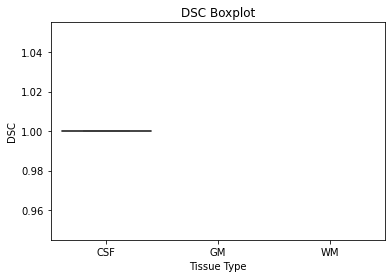

array([ 1., nan, nan])

In [40]:
visualize_dices(data_dir,data_dir)

In [26]:
import os
data_dir = 'project-data/greymatter/'
Image_list=os.listdir(data_dir)
GT_list=os.listdir(data_dir)

CSF=0
GM=0
WM=0

CSF_List=[]
GM_List=[]
WM_List=[]

In [46]:
Image_list

['wc1sub-CC722421_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC320616_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC220843_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC723395_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC710088_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC510256_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC720685_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC121428_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC320379_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC620451_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC721392_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC210124_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC720941_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC320608_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC621184_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC720516_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC320687_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC722651_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC610039_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC321594_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC710858_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC610028_T1w_rigid_to_mni.nii.gz',
 'wc1sub-CC610671_T1w_rigid_to_m

### TASK B-2: Dimensionality reduction

Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance that needs to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`).

*Note:* When dimensionality reduction is used as pre-processing step for supervised learning, as in this case, it is important that PCA is fitted to the training data only, but then applied to both the training and testing data. So make sure your implementation consists of two separate steps, 1) fitting the PCA model to $X_{\text{train}}$ (using the `fit` function), and 2) applying dimensionality reduction to $X_{\text{train}}$ and $X_{\text{test}}$ using the `transform` function.

In [19]:
n = 1000
x = np.random.normal(5,2,n)
y = 2*x + np.random.normal(0,3,n)
X = np.vstack((x,y))
m, n = X.shape
print('Dimension:\t' + str(m))
print('Samples:\t' + str(n))
mu_X = np.mean(X, axis=1)
X_prime = (1 / np.sqrt(n-1)) * (X - np.tile(mu_X, (n, 1)).T)
U, D, V = np.linalg.svd(np.matmul(X_prime,X_prime.T))

Dimension:	2
Samples:	1000


### TASK B-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) in the same way as for approach A so results can be directly compared.

Try using at least two different regression methods.

*Note:* Remember, when you use cross-validation where you swap training and testing sets in each fold, you need to fit PCA to the training set of each fold.

In [ ]:
# Your implementation